In [1]:
import jsbsim
import numpy as np
import scipy.optimize
import pandas as pd
import matplotlib.pyplot as plt
import time

from logger import Logger

fdm = jsbsim.FGFDMExec('.') # The path supplied to FGFDMExec is the location of the folders "aircraft", "engines" and "systems"

fdm.load_model('F-35B-2') # Load the aircraft 737
fdm['ic/h-sl-ft'] = 590
fdm['ic/terrain-elevation-ft'] = 584
fdm['ic/lat-geod-deg'] = 40.4110213580397
fdm['ic/long-gc-deg'] = -86.92756398413263
fdm['ic/psi-true-deg'] = 279.17
fdm['gear/gear-pos-norm'] = 1
fdm['gear/gear-cmd-norm'] = 1
fdm['fcs/speedbrake-cmd-norm'] = 0
fdm['fcs/mixture-pos-norm'] = 1
fdm['fcs/mixture-cmd-norm'] = 1


def python_trim(fdm):

    def cost(xd):
        fdm['propulsion/engine/pitch-angle-rad'] = np.deg2rad(90)
        fdm['fcs/throttle-cmd-norm'] = xd[0]
        fdm['fcs/aileron-cmd-norm'] = xd[1]
        fdm['fcs/elevator-cmd-norm'] = xd[2]
        fdm['fcs/rudder-cmd-norm'] = xd[3]

        prop = fdm.get_propulsion()
        for i in range(prop.get_num_engines()):
            prop.init_running(i)
        fdm.run_ic()

        udot = fdm['accelerations/udot-ft_sec2']
        vdot = fdm['accelerations/vdot-ft_sec2']
        wdot = fdm['accelerations/wdot-ft_sec2']
        pdot = fdm['accelerations/pdot-rad_sec2']
        qdot = fdm['accelerations/qdot-rad_sec2']
        rdot = fdm['accelerations/rdot-rad_sec2']
        
        return udot**2 + vdot**2 + wdot**2 + pdot**2 + qdot**2 + rdot**2

    bounds = [[0, 2], [-1, 1], [-1, 1], [-1, 1]]
    res = scipy.optimize.minimize(fun=cost, x0=[0.5, 0, 0, 0], bounds=bounds, tol=1e-30)
    print(res)
    return {
        'fcs/throttle-cmd-norm': res['x'][0],
        'fcs/roll-trim-cmd-norm': res['x'][1],
        'fcs/pitch-trim-cmd-norm': res['x'][2],
        'fcs/yaw-trim-cmd-norm': res['x'][3],
    }

trim = python_trim(fdm)
trim

      fun: 9.362524954088128e-12
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.03304306e-06, -3.41414848e-09,  1.78312366e-08,  0.00000000e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 460
      nit: 22
     njev: 92
   status: 0
  success: True
        x: array([ 9.70994480e-01, -3.25542122e-08, -2.03681883e-01,  0.00000000e+00])


{'fcs/throttle-cmd-norm': 0.9709944801615384,
 'fcs/roll-trim-cmd-norm': -3.255421217043766e-08,
 'fcs/pitch-trim-cmd-norm': -0.20368188251993705,
 'fcs/yaw-trim-cmd-norm': 0.0}

In [2]:
def simulate(fdm, realtime=False):
    log = Logger()
    nice = True
    sleep_nseconds = 1000
    initial_seconds = time.time()
    frame_duration = fdm.get_delta_t()

    for key in trim.keys():
        fdm[key] = trim[key]

    fdm.set_sim_time(0)
    fdm.set_output_directive('data_output/flightgear.xml')
    prop = fdm.get_propulsion()
    for i in range(prop.get_num_engines()):
        prop.init_running(i)
    result = fdm.run_ic()
    
    set_trim = False
    set_gear = False
    
    fdm['gear/gear-pos-norm'] = 1
    fdm['gear/gear-cmd-norm'] = 1

    while result and fdm.get_sim_time() < 50:
        t = fdm.get_sim_time()
        if not set_trim and t > 30:
            set_trim = True
            for key in trim.keys():
                fdm[key] = trim[key]
        
        if not set_gear and t > 35:
            fdm['gear/gear-cmd-norm'] = 0

        if realtime:
            current_seconds = time.time()
            actual_elapsed_time = current_seconds - initial_seconds
            sim_lag_time = actual_elapsed_time - fdm.get_sim_time()

            for _ in range(int(sim_lag_time / frame_duration)):
                result = fdm.run()
                current_seconds = time.time()
        else:
            result = fdm.run()
            if nice:
                time.sleep(sleep_nseconds / 1000000.0)
        log.new_frame(
            t, fdm.get_property_catalog(''))

    log = log.to_pandas()
    return log

log = simulate(fdm, realtime=False)

In [3]:
fdm.get_property_catalog('')

{'inertial/sea-level-radius_ft': 20896306.02762574,
 'simulation/gravity-model': 1.0,
 'simulation/integrator/rate/rotational': 1.0,
 'simulation/integrator/rate/translational': 3.0,
 'simulation/integrator/position/rotational': 1.0,
 'simulation/integrator/position/translational': 4.0,
 'simulation/write-state-file': 0.0,
 'simulation/channel-dt': 0.008333333333333333,
 'simulation/gravitational-torque': 0.0,
 'simulation/force-output': 0.0,
 'simulation/do_simple_trim': 0.0,
 'simulation/reset': 0.0,
 'simulation/disperse': 0.0,
 'simulation/randomseed': 0.0,
 'simulation/terminate': 0.0,
 'simulation/pause': -253231104.0,
 'simulation/sim-time-sec': 50.00833333333114,
 'simulation/dt': 0.008333333333333333,
 'simulation/jsbsim-debug': 1.0,
 'simulation/frame': 6001.0,
 'simulation/trim-completed': 0.0,
 'velocities/h-dot-fps': 3.536899290401789e-05,
 'velocities/v-north-fps': -0.004388757765768596,
 'velocities/v-east-fps': -0.0027835018269929614,
 'velocities/v-down-fps': -3.536899

<AxesSubplot:xlabel='t, sec'>

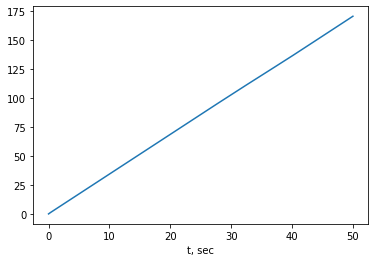

In [7]:
log['propulsion/engine[1]/fuel-used-lbs'].plot()